In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree as tree

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

import math
import random
from tqdm import tqdm, trange

import seaborn as sns

seed = 42

random.seed(seed)

In [68]:
df = pd.read_csv('extracted.dataset')
features = df.columns[:8]
targets = df.target
print(df.shape)

targets.value_counts()


(32365, 9)


0    8965
1    8400
3    7500
2    7500
Name: target, dtype: int64

In [69]:
for feature in features:
    print(feature)
    print(len(df.loc[df[feature] == 0]))
    print

nodes
0
nodes_merged
0
distinct_features
0
functions
4
lambdas
11112
applications
4
variables
290
constants
37


In [75]:
(len(df)-11112)/len(df)*100

65.6666151707091

In [45]:
def correlation(labels, targets, target_mean, target_denomenator):
    label_mean = sum(labels)/len(labels)
    
    numerator = sum(((x - label_mean)*(y - target_mean) for x,y in zip(labels, targets)))
    denomenator = math.sqrt(sum((x - label_mean)**2 for x in labels)) * target_denomenator
    
    return numerator/denomenator

# Bootstrap Test

In [46]:
target_mean = sum(targets)/len(targets)
target_denomenator = math.sqrt(sum((y - target_mean)**2 for y in targets))

In [47]:
# correlations = []
# for i in trange(1000000):
#     labels = random.choices([0,1,2,3], k=len(targets))
#     correlations.append(correlation(labels, targets, target_mean, target_denomenator))


# correlations array contains the correlation values for 1 000 000 randomly chosen labellings of the target set
correlations = np.loadtxt('correlation_pvalues.csv', delimiter=',')

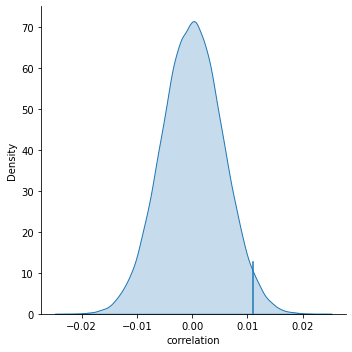

In [48]:
correlations = sorted(correlations)
cutoff = correlations[math.ceil(len(correlations)*0.975)]
correlation_df = pd.DataFrame(data={'correlation': correlations})

sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
plt.axvline(cutoff, 0, 0.17)
plt.show()

# Data Preparation

In [49]:
x = df.values
scaler = preprocessing.MinMaxScaler()
scaled_x = scaler.fit_transform(x)
df = pd.DataFrame(data=scaled_x, columns=df.columns)
df.target = targets
df.head()

,nodes,nodes_merged,distinct_features,functions,lambdas,applications,variables,constants,target
0,0.005588,0.043912,0.133333,0.005698,0.000000,0.006887,0.010239,0.004088,0
1,0.002235,0.023952,0.116667,0.002279,0.004545,0.002066,0.005119,0.001635,0
2,0.001118,0.013972,0.083333,0.001140,0.000000,0.001377,0.003413,0.000818,0
3,0.005588,0.047904,0.150000,0.005698,0.009091,0.005510,0.010239,0.004088,0
4,0.004470,0.043912,0.150000,0.004558,0.004545,0.004821,0.008532,0.003271,0


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(df[features], targets, test_size=1/3, shuffle=True, random_state=seed)
len(X_train), len(X_test)

(21576, 10789)

In [51]:
target_mean = sum(Y_test)/len(Y_test)
target_denomenator = math.sqrt(sum((y - target_mean)**2 for y in Y_test))

# Random and Majority Class baselines

In [52]:
def random_classifier(n_predictions):
    return random.choices([0,1,2,3], k=n_predictions)

def majority_classifier(labels, n_predictions):
    label_counts = dict()
    for y in labels:
        if y in label_counts:
            label_counts[y] += 1
        else:
            label_counts[y] = 1
    
    majority = None
    majority_count = 0
    for k,v in label_counts.items():
        if v > majority_count:
            majority_count = v
            majority = k
    
    return [majority for _ in range(n_predictions)]

In [53]:
random_preds = random_classifier(len(Y_test))
majority_preds = majority_classifier(Y_train, len(Y_test))

random_index = random.randint(0, len(majority_preds)-1)
majority_preds[random_index] = 1

print(correlation(random_preds, Y_test, target_mean, target_denomenator))
print(sum((majority_preds == Y_test))/len(Y_test))

-0.009138339442286243
0.280378162943739


# Viz Code

In [54]:
def plot_results(results_df, confused=True):
    sns.regplot(x="targets", y="predictions", data=results_df)
    sns.catplot(x="targets", y="predictions", kind="box", data=results_df)
    if confused:
        print(confusion_matrix(Y_test, preds))
    

# Decision Tree Experiment

In [55]:
# accs = list()
# corrs = list()
# for i in trange(100):
#     decision_tree = DecisionTreeClassifier(min_samples_split=20, max_depth=3, criterion='entropy', random_state=i)
#     decision_tree.fit(X_train, Y_train)

#     preds = decision_tree.predict(X_test)
#     results = (preds == Y_test)
#     results = [1 if x == True else 0 for x in results]
#     accs.append(sum(results)/len(results) * 100)
    
#     corrs.append(correlation(preds, Y_test, target_mean, target_denomenator))

# print(f'Accuracy: {sum(accs)/len(accs)}')
# print(f'Min Corr: {min(corrs)}, Max Corr: {max(corrs)}')

# results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})
# plot_results(results_df)

0.3320067300306607


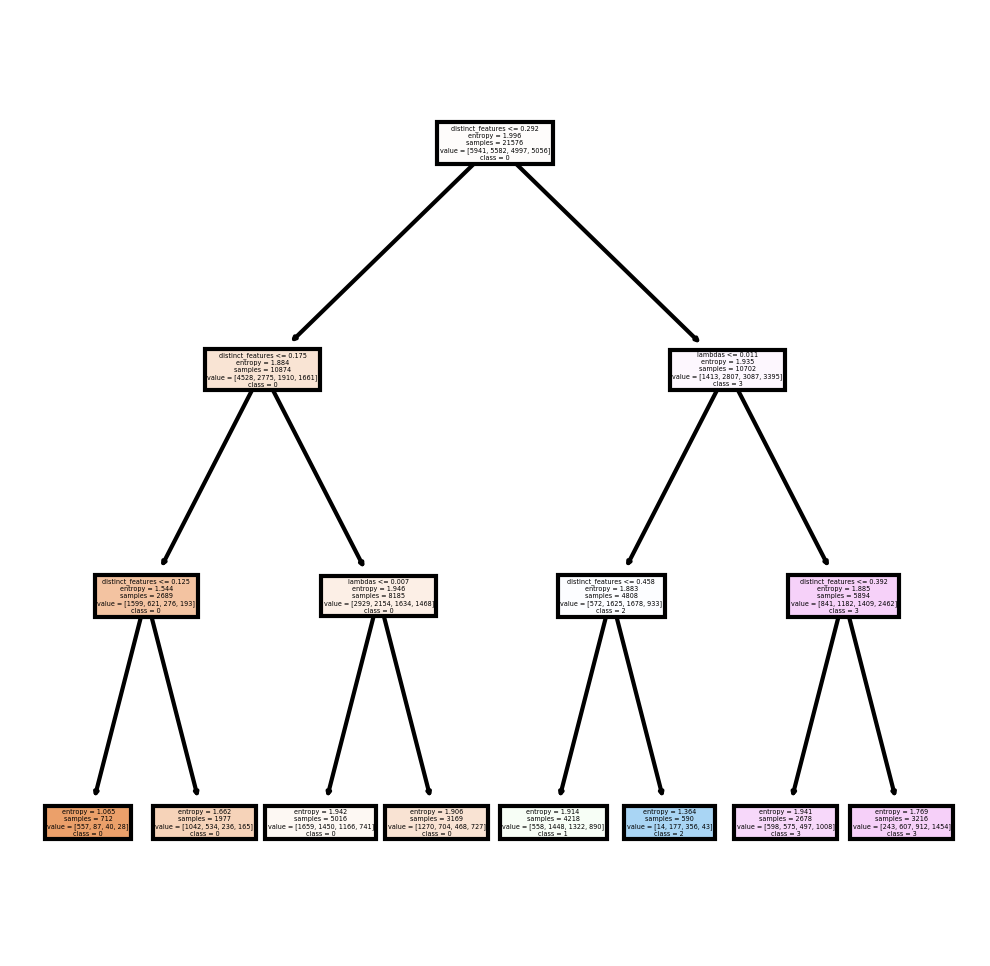

In [59]:

decision_tree = DecisionTreeClassifier(min_samples_split=20, max_depth=3, criterion='entropy', random_state=42)
decision_tree.fit(X_train, Y_train)

preds = decision_tree.predict(X_test)
classifier_corr = correlation(preds, Y_test, target_mean, target_denomenator)
print(classifier_corr)

# corrs = []
# Y_test_copy = np.array(Y_test.copy())
# for i in trange(1000):
#     np.random.shuffle(Y_test_copy)
#     corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))

# correlations = sorted(corrs)
# cutoff = correlations[math.ceil(len(correlations)*0.975)]
# correlation_df = pd.DataFrame(data={'correlation': correlations})

# sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
# plt.axvline(cutoff, 0, 0.17)
# plt.show()

# print(classifier_corr)

visualize_tree = True

if visualize_tree:
    cn = ['0','1','2','3']

    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    tree.plot_tree(decision_tree,
                   feature_names = features, 
                   class_names=cn,
                   filled = True);
    fig.savefig('absolute_decision_tree.png')

# results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})
# plot_results(results_df)

# Gaussian Naive Bayes Code

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 35.749374362776905
Min Corr: 0.318079187368858, Max Corr: 0.318079187368858


100%|██████████| 1000/1000 [01:39<00:00, 10.05it/s]


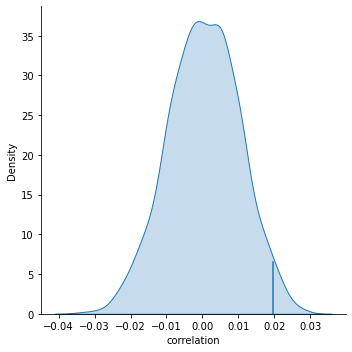

[[1985  864   90   85]
 [1210 1275  211  122]
 [ 718 1292  320  173]
 [ 579 1224  364  277]]


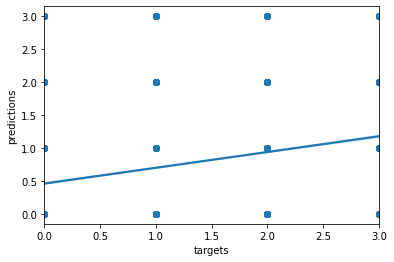

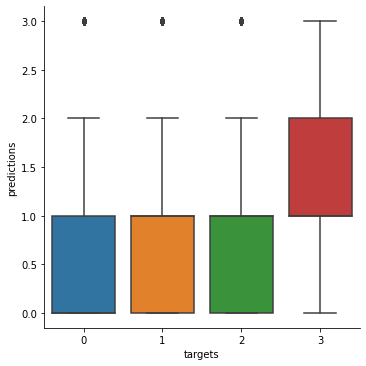

In [15]:
accs = list()
corrs = list()
for i in trange(1):    
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    preds = gnb.predict(X_test)

    results = (preds == Y_test)
    results = [1 if x == True else 0 for x in results]
    accs.append(sum(results)/len(results) * 100)
    
    corrs.append(correlation(preds, Y_test, target_mean, target_denomenator))

print(f'Accuracy: {sum(accs)/len(accs)}')
print(f'Min Corr: {min(corrs)}, Max Corr: {max(corrs)}')

corrs = []
Y_test_copy = np.array(Y_test.copy())
for i in trange(1000):
    np.random.shuffle(Y_test_copy)
    corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))

correlations = sorted(corrs)
cutoff = correlations[math.ceil(len(correlations)*0.975)]
correlation_df = pd.DataFrame(data={'correlation': correlations})

sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
plt.axvline(cutoff, 0, 0.17)
plt.show()

results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})
plot_results(results_df)

# Linear Regression

  0%|          | 2/1000 [00:00<00:52, 18.90it/s]

Correlation: 0.3104290556373245


100%|██████████| 1000/1000 [00:38<00:00, 25.94it/s]


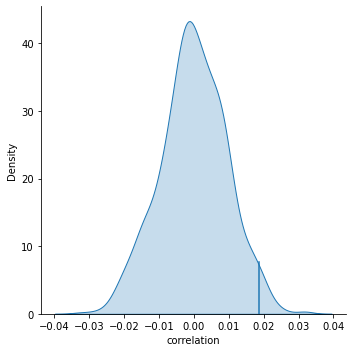

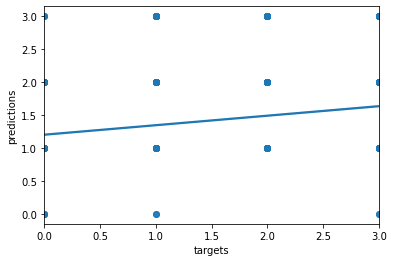

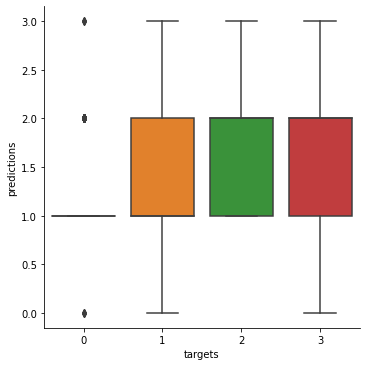

In [16]:
reg = LinearRegression().fit(X_train, Y_train)
reg.score(X_train, Y_train)
preds = reg.predict(X_test)
preds = np.rint(preds)
for i, x in enumerate(preds):
    if x < 0:
        preds[i] = 0
    elif x > 3:
        preds[i] = 3
print(f'Correlation: {correlation(preds, Y_test, target_mean, target_denomenator)}')

corrs = []
Y_test_copy = np.array(Y_test.copy())
for i in trange(1000):
    np.random.shuffle(Y_test_copy)
    corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))

correlations = sorted(corrs)
cutoff = correlations[math.ceil(len(correlations)*0.975)]
correlation_df = pd.DataFrame(data={'correlation': correlations})

sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
plt.axvline(cutoff, 0, 0.17)
plt.show()
                      
results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})
plot_results(results_df, confused=False)

In [17]:
df1 = pd.read_csv(f'plotting_without_MLP_V/classic: 0 hops/classic: 0 hops_epoch_30')
df1

,Unnamed: 0,Predictions,Labels,epoch
0,0,3,3,30
1,1,0,0,30
2,2,2,2,30
3,3,2,1,30
4,4,1,1,30
...,...,...,...,...
10784,10784,1,3,30
10785,10785,3,0,30
10786,10786,0,0,30
10787,10787,0,0,30


In [18]:
target_mean = sum(df1.Predictions)/len(df1.Predictions)
target_denomenator = math.sqrt(sum((y - target_mean)**2 for y in df1.Predictions))

correlation(df1.Predictions, df1.Labels, target_mean, target_denomenator)

0.6100522786834277

# Relative Difficulty

## Data Prep

## Split Data and join pairs of theorems

In [62]:
# Read Data
df = pd.read_csv('extracted.dataset')
features = df.columns[:8]
targets = df.target




# Scale Data
x = df.values
scaler = preprocessing.MinMaxScaler()
scaled_x = scaler.fit_transform(x)
df = pd.DataFrame(data=scaled_x, columns=df.columns)
df.target = targets




# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(df[features], targets, test_size=1/3, shuffle=True, random_state=seed)



# Reduce size to be consistent with GNN experiment
X_train_1, X_train_2 = X_train[32:], X_train[:-32]
Y_train_1, Y_train_2 = Y_train[32:], Y_train[:-32]
X_test_1, X_test_2 = X_test[32:], X_test[:-32]
Y_test_1, Y_test_2 = Y_test[32:], Y_test[:-32]


# Merge pairs of theorems
X_train_1.columns = [x+'_1' for x in X_train_1.columns]
X_train_2.columns = [x+'_2' for x in X_train_2.columns]
columns = list(X_train_1.columns) + list(X_train_2.columns)
values = np.concatenate([X_train_1.values, X_train_2.values], axis=1)
X_train = pd.DataFrame(data=values, columns=columns)


X_test_1.columns = [x+'_1' for x in X_test_1.columns]
X_test_2.columns = [x+'_2' for x in X_test_2.columns]
columns = list(X_test_1.columns) + list(X_test_2.columns)
values = np.concatenate([X_test_1.values, X_test_2.values], axis=1)
X_test = pd.DataFrame(data=values, columns=columns)

Y_train = []
for y_1, y_2 in zip(Y_train_1, Y_train_2):
    if y_1 < y_2:
        Y_train.append(0)
    elif y_1 == y_2:
        Y_train.append(1)
    else:
        Y_train.append(2)

Y_test = []
for y_1, y_2 in zip(Y_test_1, Y_test_2):
    if y_1 < y_2:
        Y_test.append(0)
    elif y_1 == y_2:
        Y_test.append(1)
    else:
        Y_test.append(2)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Set up for measuring correlation
target_mean = sum(Y_test)/len(Y_test)
target_denomenator = math.sqrt(sum((y - target_mean)**2 for y in Y_test))

0.3094383830652035
Accuracy: 49.986055591707725


  0%|          | 2/1000 [00:00<01:32, 10.77it/s]

[[2754  223 1057]
 [1404  226 1088]
 [1325  283 2397]]


100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


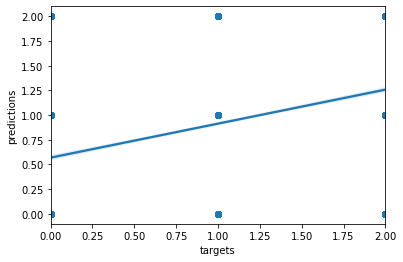

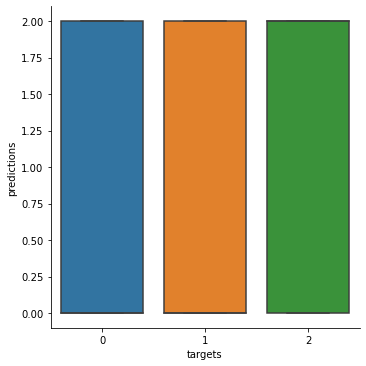

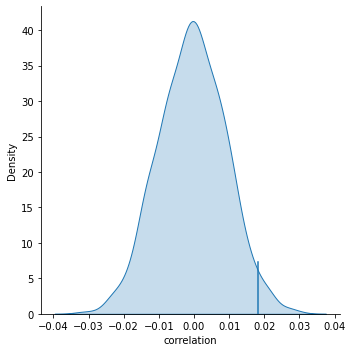

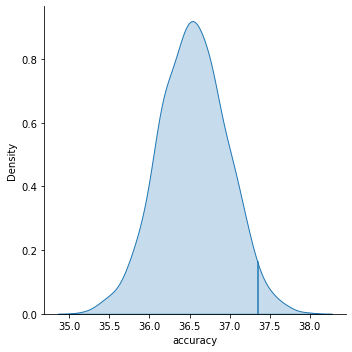

In [63]:
corrs = []
decision_tree = DecisionTreeClassifier(min_samples_split=20, max_depth=8, criterion='entropy', random_state=42)
decision_tree.fit(X_train, Y_train)

preds = decision_tree.predict(X_test)
classifier_corr = correlation(preds, Y_test, target_mean, target_denomenator)
# print(classifier_corr)

Y_test_copy = np.array(Y_test.copy())
# for i in trange(1000):
#     np.random.shuffle(Y_test_copy)
#     corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))

# correlations = sorted(corrs)
# cutoff = correlations[math.ceil(len(correlations)*0.975)]
# correlation_df = pd.DataFrame(data={'correlation': correlations})

# sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
# plt.axvline(cutoff, 0, 0.17)
# plt.show()

print(classifier_corr)

results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})

results = (preds == Y_test)
results = [1 if x == True else 0 for x in results]
print(f'Accuracy: {sum(results)/len(results) * 100}')
plot_results(results_df)


visualize_tree = False

if visualize_tree:
    cn = ['Smaller','Same', 'Bigger']

    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    tree.plot_tree(decision_tree,
                   feature_names = columns, 
                   class_names=cn,
                   filled = True);
    fig.savefig('imagename.png')
    

corrs = []
accs = []
Y_test_copy = np.array(Y_test.copy())
for i in trange(1000):
    np.random.shuffle(Y_test_copy)
    corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))
    results = (preds == Y_test_copy)
    results = [1 if x == True else 0 for x in results]
    accs.append(sum(results)/len(results) * 100)

correlations = sorted(corrs)
accs = sorted(accs)
cutoff_corr = correlations[math.ceil(len(correlations)*0.975)]
cutoff_acc = accs[math.ceil(len(accs)*0.975)]
correlation_df = pd.DataFrame(data={'correlation': correlations})
acc_df = pd.DataFrame(data={'accuracy': accs})

sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
plt.axvline(cutoff_corr, 0, 0.17)
plt.show()

sns.displot(acc_df, x="accuracy", kind="kde", fill=True)
plt.axvline(cutoff_acc, 0, 0.17)
plt.show()

  0%|          | 2/1000 [00:00<01:28, 11.25it/s]

Accuracy: 48.88909547271545
Min Corr: 0.27724206659761275, Max Corr: 0.27724206659761275


100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]


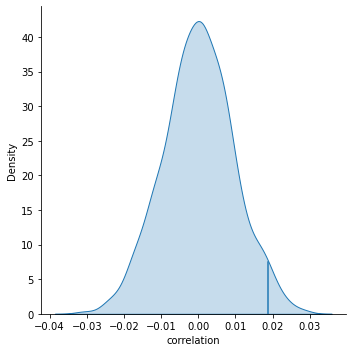

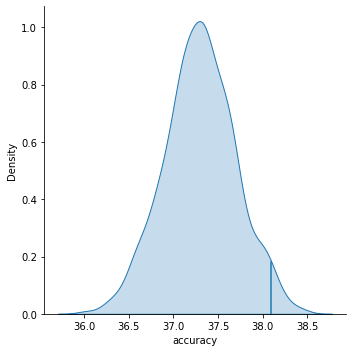

[[2127   11 1896]
 [1022    9 1687]
 [ 869   13 3123]]


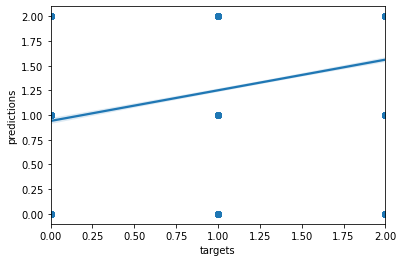

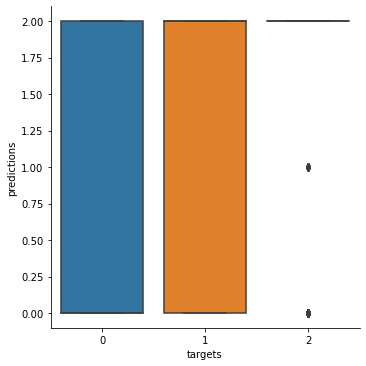

In [64]:
accs = list()
corrs = list()
for i in trange(1):    
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    preds = gnb.predict(X_test)

    results = (preds == Y_test)
    results = [1 if x == True else 0 for x in results]
    accs.append(sum(results)/len(results) * 100)
    
    corrs.append(correlation(preds, Y_test, target_mean, target_denomenator))

print(f'Accuracy: {sum(accs)/len(accs)}')
print(f'Min Corr: {min(corrs)}, Max Corr: {max(corrs)}')

corrs = []
accs = []
Y_test_copy = np.array(Y_test.copy())
for i in trange(1000):
    np.random.shuffle(Y_test_copy)
    corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))
    results = (preds == Y_test_copy)
    results = [1 if x == True else 0 for x in results]
    accs.append(sum(results)/len(results) * 100)

correlations = sorted(corrs)
accs = sorted(accs)
cutoff_corr = correlations[math.ceil(len(correlations)*0.975)]
cutoff_acc = accs[math.ceil(len(accs)*0.975)]
correlation_df = pd.DataFrame(data={'correlation': correlations})
acc_df = pd.DataFrame(data={'accuracy': accs})

sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
plt.axvline(cutoff_corr, 0, 0.17)
plt.show()

sns.displot(acc_df, x="accuracy", kind="kde", fill=True)
plt.axvline(cutoff_acc, 0, 0.17)
plt.show()

results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})
plot_results(results_df)

In [66]:
reg = LinearRegression().fit(X_train, Y_train)
reg.score(X_train, Y_train)
preds = reg.predict(X_test)
# preds = np.rint(preds)
# for i, x in enumerate(preds):
#     if x < 0:
#         preds[i] = 0
#     elif x > 2:
#         preds[i] = 2
print(f'Correlation: {correlation(preds, Y_test, target_mean, target_denomenator)}')

results = (preds == Y_test)
results = [1 if x == True else 0 for x in results]
print(f'Accuracy: {sum(results)/len(results)}')

corrs = []
accs = []
Y_test_copy = np.array(Y_test.copy())
for i in trange(1000):
    np.random.shuffle(Y_test_copy)
    corrs.append(correlation(preds, Y_test_copy, target_mean, target_denomenator))
    results = (preds == Y_test_copy)
    results = [1 if x == True else 0 for x in results]
    accs.append(sum(results)/len(results) * 100)

correlations = sorted(corrs)
accs = sorted(accs)
cutoff_corr = correlations[math.ceil(len(correlations)*0.975)]
cutoff_acc = accs[math.ceil(len(accs)*0.975)]
correlation_df = pd.DataFrame(data={'correlation': correlations})
acc_df = pd.DataFrame(data={'accuracy': accs})

sns.displot(correlation_df, x="correlation", kind="kde", fill=True)
plt.axvline(cutoff_corr, 0, 0.17)
plt.show()

sns.displot(acc_df, x="accuracy", kind="kde", fill=True)
plt.axvline(cutoff_acc, 0, 0.17)
plt.show()
                      
results_df = pd.DataFrame(data={'targets': Y_test, 'predictions': preds})
plot_results(results_df, confused=False)

  0%|          | 2/1000 [00:00<00:57, 17.34it/s]

Correlation: 0.3536017361762054
Accuracy: 0.0


 20%|██        | 201/1000 [00:10<00:40, 19.77it/s]


KeyboardInterrupt: 